# Part 3: ALICES baseline analysis

## Preparations

In [1]:
%matplotlib inline

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys
from scipy.stats import norm

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

sys.path.append("/Users/johannbrehmer/work/projects/madminer/madminer")
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator

sys.path.append("/Users/johannbrehmer/work/projects/manifold_flow/manifold-flow")
from experiments.evaluation import mcmc

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)
        


13:03 madminer             INFO    
13:03 madminer             INFO    ------------------------------------------------------------------------
13:03 madminer             INFO    |                                                                      |
13:03 madminer             INFO    |  MadMiner v0.7.1                                                     |
13:03 madminer             INFO    |                                                                      |
13:03 madminer             INFO    |         Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer  |
13:03 madminer             INFO    |                                                                      |
13:03 madminer             INFO    ------------------------------------------------------------------------
13:03 madminer             INFO    
13:03 experiments.training WARNING geomloss not found, let's hope that you started a training method that doesn't need it!


## Generate training data

In [2]:
sampler = SampleAugmenter('data/delphes_data.h5')

10:09 madminer.analysis.da INFO    Loading data from data/delphes_data.h5
10:09 madminer.analysis.da INFO    Found 2 parameters
10:09 madminer.analysis.da INFO    Did not find nuisance parameters
10:09 madminer.analysis.da INFO    Found 6 benchmarks, of which 6 physical
10:09 madminer.analysis.da INFO    Found 48 observables
10:09 madminer.analysis.da INFO    Found 630610 events
10:09 madminer.analysis.da INFO      105696 signal events sampled from benchmark morphing_basis_vector_0
10:09 madminer.analysis.da INFO      101737 signal events sampled from benchmark morphing_basis_vector_1
10:09 madminer.analysis.da INFO      106743 signal events sampled from benchmark morphing_basis_vector_2
10:09 madminer.analysis.da INFO      102700 signal events sampled from benchmark morphing_basis_vector_3
10:09 madminer.analysis.da INFO      104279 signal events sampled from benchmark morphing_basis_vector_4
10:09 madminer.analysis.da INFO      109455 signal events sampled from benchmark morphing_bas

In [3]:
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    theta0=sampling.random_morphing_points(1000, [('gaussian', 0., 1.0), ('gaussian', 0., 1.0)]),
    theta1=sampling.morphing_point([0.,0.]),
    n_samples=1000000,
    folder='./data/samples',
    filename='train_ratio',
    sample_only_from_closest_benchmark=True,
    return_individual_n_effective=True,
)

18:30 madminer.sampling    INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: 1000 random morphing points, drawn from the following priors:
  theta_0 ~ Gaussian with mean 0.0 and std 1.0
  theta_1 ~ Gaussian with mean 0.0 and std 1.0, denominator hypothesis: [0. 0.]
18:30 madminer.sampling    INFO    Starting sampling serially
18:30 madminer.sampling    INFO    Sampling from parameter point 50 / 1000
18:30 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [ 0.39923188 -0.23322676]: (0.003817 +/- 0.000416) pb (10.895047869081584 %). Skipping these warnings in the future...
18:31 madminer.sampling    INFO    Sampling from parameter point 100 / 1000
18:31 madminer.sampling    INFO    Sampling from parameter point 150 / 1000
18:31 madminer.sampling    INFO    Sampling from parameter point 200 / 1000
18:31 madminer.sampling    INFO    Sampling from parameter point 250 / 1000
18:32 madminer.sampling

## Train likelihood ratio estimators with ALICES method

In [7]:
for i in range(5,10):
    logging.info("Let's go run %s!", i + 1)
    
    estimator = ParameterizedRatioEstimator(
        n_hidden=(100, 100, 100,),
        activation="tanh"
    )
    estimator.train(
        method='alices',
        theta='data/samples/theta0_train_ratio.npy',
        x='data/samples/x_train_ratio.npy',
        y='data/samples/y_train_ratio.npy',
        r_xz='data/samples/r_xz_train_ratio.npy',
        t_xz='data/samples/t_xz_train_ratio.npy',
        alpha=1.,
        n_epochs=50,
    )
    estimator.save('models/alices{}'.format("" if i == 0 else "_run{}".format(i)))
    

10:11 root                 INFO    Let's go run 6!
10:43 root                 INFO    Let's go run 7!
11:17 root                 INFO    Let's go run 8!
11:51 root                 INFO    Let's go run 9!
12:27 root                 INFO    Let's go run 10!


## Evaluate likelihood ratio on grid

In [12]:
theta_each = np.linspace(-1,1,11)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)


In [13]:
estimator.load('models/alices')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

20:02 madminer.ml          INFO    Loading model from models/alices
20:02 madminer.ml          INFO    Loading evaluation data
20:02 madminer.utils.vario INFO      Loading data/samples/x_test.npy into RAM
20:02 madminer.utils.vario INFO      Loading data/samples/theta_grid.npy into RAM
20:02 madminer.ml          INFO    Starting ratio evaluation for 1210000 x-theta combinations
20:02 madminer.ml          INFO    Evaluation done


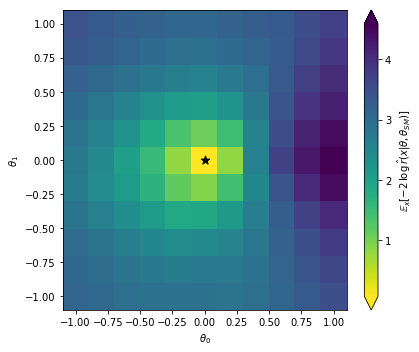

In [15]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((11,11)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


## Run MCMC

In [2]:
for key in logging.Logger.manager.loggerDict:
    if "madminer" in key:
        logging.getLogger(key).setLevel(logging.WARNING)
    if "mcmc" in key:
        logging.getLogger(key).setLevel(logging.INFO)

In [3]:
def run_mcmc(run=0, trueparam=0, chain=0, observedsamples=15, mcmcsamples=750, mcmcstep=0.15, burnin=100, thin=1):
    run_str = "" if run == 0 else "_run{}".format(run)
    trueparam_str = "" if trueparam == 0 else "_trueparam{}".format(trueparam)
    chain_str = "" if chain == 0 else "_chain{}".format(chain)
    
    # Model
    estimator = ParameterizedRatioEstimator(
        n_hidden=(100, 100, 100),
        activation="tanh"
    )
    estimator.load('models/alices{}'.format(run_str))

    # Data
    theta_true = np.load("data/samples/theta_test{}.npy".format("" if trueparam == 0 else trueparam))[0]
    x_obs = np.load("data/samples/x_test{}.npy".format("" if trueparam == 0 else trueparam))[:observedsamples]

    # MCMC based on neural likelihood estimator
    def log_posterior(params):
        params_ = np.broadcast_to(params.reshape((-1, params.shape[-1])), (x_obs.shape[0], params.shape[-1]))

        # Likelihood ratio
        log_likelihood_ratios = estimator.evaluate_log_likelihood_ratio(
            theta=params_,
            x=x_obs,
            evaluate_score=False,
            test_all_combinations=False
        )[0]
        log_prob = np.sum(log_likelihood_ratios)

        # Prior
        log_prob += np.sum(norm(loc=0.0, scale=1.0).logpdf(x=params))
        return float(log_prob)

    sampler = mcmc.GaussianMetropolis(theta_true, log_posterior, step=mcmcstep, thin=thin)

    if burnin > 0:
        logging.info("Starting burn in")
        sampler.gen(burnin)
    logging.info("Burn in done, starting main chain")
    posterior_samples = sampler.gen(mcmcsamples)
    logging.info("MCMC done")
    
    np.save(
        "../../data/results/alices_14_lhc_may{}_posterior_samples{}{}.npy".format(run_str, trueparam_str, chain_str),
        posterior_samples
    )

    return posterior_samples

In [5]:
posterior_samples = []

for run in range(10):
    for trueparam in range(3):
        for chain in range(4):
            run_mcmc(run, trueparam, chain)


13:04 root                 INFO    Starting burn in
13:04 experiments.evaluati INFO    MCMC after sample 100 = [-0.01782327  0.02756124]: acceptance rate = 0.09, log likelihood = -1.73
13:04 experiments.evaluati INFO    MCMC chain finished after 100 samples: acceptance rate = 0.09, log likelihood = -1.73
13:04 root                 INFO    Burn in done, starting main chain
13:04 experiments.evaluati INFO    MCMC after sample 100 = [0.07183249 0.0306653 ]: acceptance rate = 0.13, log likelihood = -0.91
13:04 experiments.evaluati INFO    MCMC after sample 200 = [0.03775095 0.03887029]: acceptance rate = 0.16, log likelihood = -0.75
13:04 experiments.evaluati INFO    MCMC after sample 300 = [-0.04039986  0.01041014]: acceptance rate = 0.17, log likelihood = -2.66
13:04 experiments.evaluati INFO    MCMC after sample 400 = [-0.0851248   0.07434871]: acceptance rate = 0.17, log likelihood = -3.66
13:04 experiments.evaluati INFO    MCMC after sample 500 = [0.01682045 0.07611039]: acceptance ra